In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
charging_per_day = pd.read_csv("charging_per_day.csv")
processed_df = charging_per_day.drop(columns=['Timestamp', 'Hour_0'])

In [4]:
# Setting a fixed random parameter
torch.manual_seed(42)

In [5]:
features_to_scale = ['Charging_per_day', 'MAX. TEMP(F)', 'MIN. TEMP(F)', 'Precipitation (Inches)', 'Snowfall (Inches)', 'Snow Cover (Inches)']
features = processed_df[features_to_scale]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# For boolean or one-hot features, ensure they are converted to integers
boolean_and_onehot_features = processed_df.drop(columns=features_to_scale).astype(int).values

# Concatenate scaled continuous features and boolean/one-hot features
data_normalized = np.concatenate((scaled_features, boolean_and_onehot_features), axis=1)

# Ensure the concatenated array is of a uniform numerical type that PyTorch can handle
data_normalized = np.array(data_normalized, dtype=np.float32)

# Convert to PyTorch tensor
data_normalized_tensor = torch.FloatTensor(data_normalized)

In [6]:
# Creating sequences to train on

# For the 7-day ahead task
def create_inout_sequences_multivariate(input_data, tw, prediction_gap=7):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw - prediction_gap + 1):
        seq = input_data[i:i+tw]
        label = input_data[i+tw+prediction_gap-1, 0]  # Adjusting for 7-day ahead forecasting
        inout_seq.append((seq, label))
    return inout_seq

# Splitting the dataset into train and test datasets
split_size = int(len(data_normalized_tensor) * 0.8)  # 80% of the data for training

# Split the normalized data into training and test sets
train_data = data_normalized_tensor[:split_size]
test_data = data_normalized_tensor[split_size:]

# Window size and batch size
window_size = 20
batch_size = 32

# Create sequences for training and test data with a 7-day ahead prediction
train_seqs = create_inout_sequences_multivariate(train_data, window_size, 7)
test_seqs = create_inout_sequences_multivariate(test_data, window_size, 7)


# DataLoader
class MultivariateTimeSeriesDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence, label = self.sequences[index]
        return sequence, label

# Training DataLoader
train_dataset = MultivariateTimeSeriesDataset(train_seqs)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test DataLoader (This will not be shuffled to make it a more realistic scenario)
test_dataset = MultivariateTimeSeriesDataset(test_seqs)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Using LSTM as a baseline model and we will build on transformer models post that


class EVChargingLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size=100, output_size=1):
        super(EVChargingLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        # Specifying batch_first=True for easier compatibility with input shapes
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Automatically determining batch size from input
        batch_size = input_seq.size(0)

        # Initializing hidden state for each batch
        hidden_cell = (torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device),
                       torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device))

        # Forward pass through LSTM layer
        lstm_out, _ = self.lstm(input_seq, hidden_cell)

        # Only taking the output from the final timestep
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

Epoch 1 Loss: 0.07254729137100556
Epoch 2 Loss: 0.0647118214379858
Epoch 3 Loss: 0.05699664940712629
Epoch 4 Loss: 0.05013607511365855
Epoch 5 Loss: 0.04364033778094583
Epoch 6 Loss: 0.037813578766805155
Epoch 7 Loss: 0.032566029199019624
Epoch 8 Loss: 0.02769810625317472
Epoch 9 Loss: 0.023586534791522555
Epoch 10 Loss: 0.020126361399888992
Epoch 11 Loss: 0.017356670996243204
Epoch 12 Loss: 0.015546147452874316
Epoch 13 Loss: 0.01407068046844668
Epoch 14 Loss: 0.013315701581261776
Epoch 15 Loss: 0.013005519044344072
Epoch 16 Loss: 0.012892296399783206
Epoch 17 Loss: 0.012665645210762267
Epoch 18 Loss: 0.012591642732904465
Epoch 19 Loss: 0.012465413556330733
Epoch 20 Loss: 0.012450699073572954
Epoch 21 Loss: 0.012449176662980958
Epoch 22 Loss: 0.012283004035621329
Epoch 23 Loss: 0.012050376428912083
Epoch 24 Loss: 0.011964243828077559
Epoch 25 Loss: 0.01212786466607617
Epoch 26 Loss: 0.0118038026029589
Epoch 27 Loss: 0.011748711156003453
Epoch 28 Loss: 0.011795048679535588
Epoch 29 Los

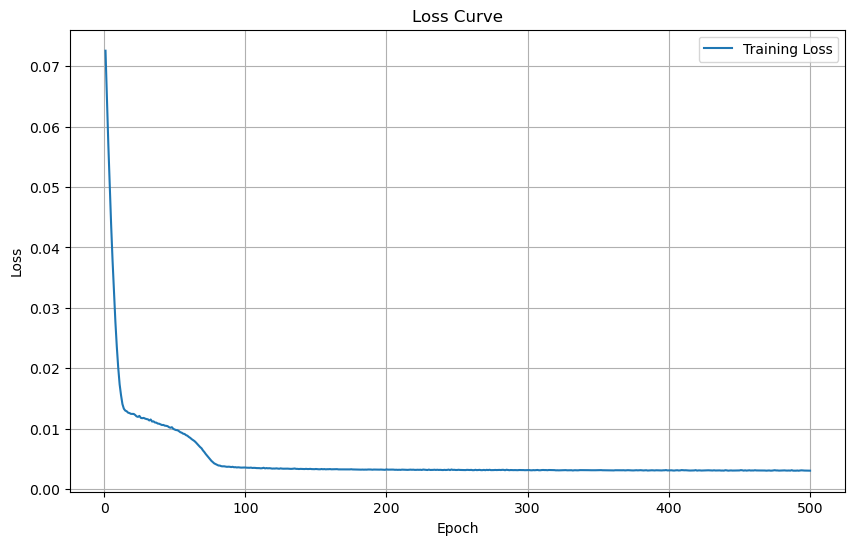

In [7]:
# Model hyperparameters
input_size = 18  
hidden_layer_size = 100
output_size = 1

# Initialize the model
model = EVChargingLSTM(input_size, hidden_layer_size, output_size)

# Loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training loop
epochs = 500
model.train()

train_loss = []

for i in range(epochs):
    epoch_loss = 0  # Initialize loss for the epoch
    n_batches = 0
    for sequences, labels in train_dataloader:
        optimizer.zero_grad()
        y_pred = model(sequences)
        loss = loss_function(y_pred, labels.unsqueeze(1))
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        n_batches += 1

    average_epoch_loss = epoch_loss / n_batches
    train_loss.append(average_epoch_loss)  # Append the average loss for the epoch
    print(f'Epoch {i+1} Loss: {average_epoch_loss}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss')  # Dynamic range based on epochs
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Evaluation LSTM
model.eval()
test_losses = []

with torch.no_grad():
    for sequences, labels in test_dataloader:
        y_test_pred = model(sequences)
        test_loss = loss_function(y_test_pred, labels.unsqueeze(1))  # Ensure label dimensions match
        test_losses.append(test_loss.item())

average_test_loss = sum(test_losses) / len(test_losses)
print(f'Test Loss: {average_test_loss}')

Test Loss: 0.026572855547643624


In [8]:
class EVChargingTransformer(nn.Module):
    def __init__(self, input_size, hidden_dim=128, output_size=1, n_layers=4, n_heads=4, dropout_rate=0.4, forward_expansion=4, max_len=20):
        super(EVChargingTransformer, self).__init__()
        
        self.embedding = nn.Linear(input_size, hidden_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(max_len, hidden_dim))
        self.layers = nn.ModuleList([
            TransformerEncoderLayerCustom(hidden_dim, n_heads, dropout_rate, forward_expansion)
            for _ in range(n_layers)
        ])
        self.out = nn.Linear(hidden_dim, output_size)
        
    def forward(self, src):
        B, T, F = src.shape  # Input shape (Batch, Time, Features)
        src = self.embedding(src.view(B*T, F)).view(B, T, -1) + self.positional_encoding[:T, :]  # (B, T, C)
        src = src.permute(1, 0, 2)  # Permute for Transformer (T, B, C)
        
        for layer in self.layers:
            src = layer(src)  # Apply each Transformer encoder layer
        
        src = src.permute(1, 0, 2)  # Permute back to (B, T, C) for the output layer
        output = self.out(src[:, -1, :])  # Use the last timestep (B, output_size)
        return output

class TransformerEncoderLayerCustom(nn.Module):
    def __init__(self, embd_size, n_heads, dropout_rate, forward_expansion):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embd_size, n_heads, dropout=dropout_rate)
        self.norm1 = nn.LayerNorm(embd_size)
        self.norm2 = nn.LayerNorm(embd_size)
        self.feed_forward = FeedForward(embd_size, dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, src):
        # Self-attention and add & norm
        attn_output, _ = self.self_attn(src, src, src)  # (T, B, C)
        src = src + self.dropout(attn_output)  # Apply residual connection
        src = self.norm1(src)  # Apply layer norm
        
        # Feedforward and add & norm
        ff_output = self.feed_forward(src)  # (T, B, C)
        src = src + self.dropout(ff_output)  # Apply residual connection
        # src = self.norm2(src)  # Apply layer norm
        return src

class FeedForward(nn.Module):
    def __init__(self, embd_size, dropout_rate):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embd_size, 4 * embd_size),
            nn.ReLU(),
            nn.Linear(4 * embd_size, embd_size),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        return self.net(x)  # (T, B, C)



Epoch 1/100, Average Loss: 0.08328116333319081
Epoch 2/100, Average Loss: 0.022669111447477783
Epoch 3/100, Average Loss: 0.017907173045117547
Epoch 4/100, Average Loss: 0.015428922604769468
Epoch 5/100, Average Loss: 0.012135929798845339
Epoch 6/100, Average Loss: 0.008319533507650098
Epoch 7/100, Average Loss: 0.00740202853490633
Epoch 8/100, Average Loss: 0.006829995963791454
Epoch 9/100, Average Loss: 0.006094216610546465
Epoch 10/100, Average Loss: 0.00569816803369947
Epoch 11/100, Average Loss: 0.005592084028413174
Epoch 12/100, Average Loss: 0.005363729562506908
Epoch 13/100, Average Loss: 0.005436214549397981
Epoch 14/100, Average Loss: 0.005204763293645724
Epoch 15/100, Average Loss: 0.004745343954440344
Epoch 16/100, Average Loss: 0.00512922443104563
Epoch 17/100, Average Loss: 0.004533988660787819
Epoch 18/100, Average Loss: 0.004651604569517076
Epoch 19/100, Average Loss: 0.004413923347817251
Epoch 20/100, Average Loss: 0.004455853374329982
Epoch 21/100, Average Loss: 0.004

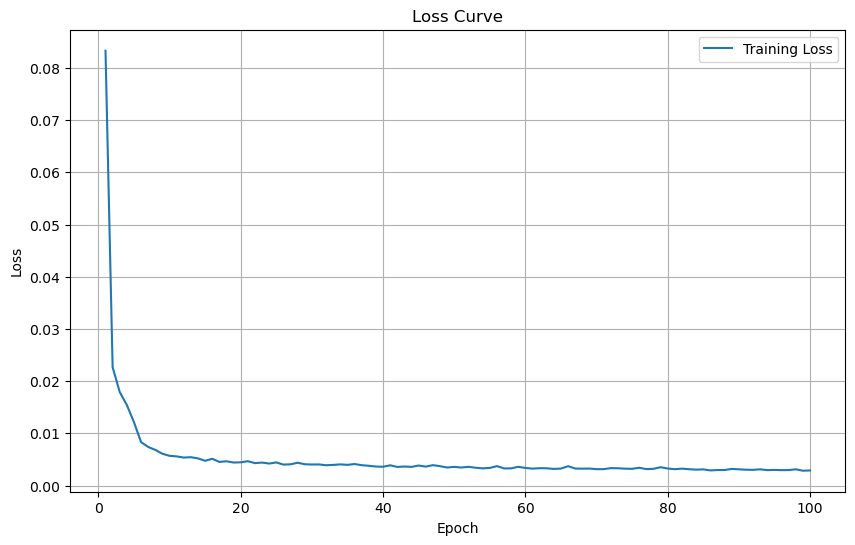

In [9]:
# Initialize the Transformer model
input_size = 18  # Number of input features
hidden_dim = 32  # Hidden dimension size
output_size = 1  # Predicting 'Charging_per_day'
n_layers = 4  # Number of Transformer layers
n_heads = 4  # Number of heads in the multi-head attention mechanism

model_transformer = EVChargingTransformer(input_size, hidden_dim, output_size, n_layers, n_heads)

# Loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model_transformer.parameters(), lr=0.001)

epochs = 100  # Number of epochs
model_transformer.train()
train_loss = []  # Initialize the list to hold the average loss per epoch

for epoch in range(epochs):
    total_loss = 0  # Accumulate loss for each epoch
    num_batches = 0  # Count the number of batches processed
    
    for sequences, labels in train_dataloader:
        optimizer.zero_grad()
        # sequences_input = sequences.permute(1, 0, 2)  # Correct permutation
        predictions = model_transformer(sequences)
        labels = labels.view(-1,1)
        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1
    
    epoch_loss = total_loss / num_batches  # Compute the average loss for the epoch
    train_loss.append(epoch_loss)  # Append the average loss of the epoch to the list
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {epoch_loss}')


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss')  # Dynamic range based on epochs
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Evaluation Transformer 
model_transformer.eval()
test_losses = []

with torch.no_grad():
    for sequences, labels in test_dataloader:
        y_test_pred = model_transformer(sequences)
        test_loss = loss_function(y_test_pred, labels.unsqueeze(1))  # Ensure label dimensions match
        test_losses.append(test_loss.item())

average_test_loss = sum(test_losses) / len(test_losses)
print(f'Test Loss: {average_test_loss}')

Test Loss: 0.02454652415158657
